# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

# Task to be performed:
* Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.
* Same as that of K-means, plot word clouds for each cluster.
* we can take around 5000 reviews or so(as this is very computationally expensive one)
to perform hierarchical clustering because they do take a considerable amount of time to
run.

In [125]:
import numpy as np 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score 
from sklearn.metrics import accuracy_score,precision_score,recall_score,classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import sqlite3

In [126]:
con = sqlite3.connect("./amazon-fine-food-reviews/database.sqlite")
data = pd.read_sql_query('''
SELECT *
FROM REVIEWS
WHERE SCORE != 3''', con)
data.shape

(525814, 10)

# Data Cleaning

In [127]:
data = data[data.HelpfulnessNumerator <= data.HelpfulnessDenominator]
data.shape

(525812, 10)

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [128]:
data['Score'] = data["Score"].apply(lambda x: "positive" if x > 3 else "negative")
sorted_data = data.sort_values('ProductId',axis = 0, inplace = False, kind = 'quicksort',ascending = True)
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138693,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,positive,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci..."
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,positive,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books..."
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,positive,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...


In [129]:
filtered_data = sorted_data.drop_duplicates(subset = {'UserId','ProfileName','Time'} ,keep = 'first', inplace = False)
filtered_data.shape

(328770, 10)

In [130]:
final = filtered_data.copy()
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\manish
[nltk_data]     dogra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [131]:
stop = set(stopwords.words("english"))
st = PorterStemmer()

##  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [132]:
def cleanhtml(sent):
    cleanr = re.compile('<.*?>')
    cleaned = re.sub(cleanr,' ',sent)
    return cleaned
def cleanpunc(sent):
    clean = re.sub(r'[?|!|$|#|\'|"|:]',r'',sent)
    clean = re.sub(r'[,|(|)|.|\|/]',r' ',clean)
    return clean

In [133]:
i=0
all_positive_reviews =[]
all_negative_reviews = []
final_string = []
stem_data = " "
for p in final['Text'].values:
    filtered_sens = []#filtered word
    p = cleanhtml(p)
    for w in p.split():
       # print(w)
        punc = cleanpunc(w)
        for s in punc.split():
            #print(w)
            if (s.isalpha()) & (len(s)>2):
                if s.lower() not in stop:
                    stem_data = (st.stem(s.lower())).encode('utf8')
                    #can we use lemmatizer and stemming altogether??
                    filtered_sens.append(stem_data)
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_reviews.append(stem_data)
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_reviews.append(stem_data)
                else:
                    continue
            else:
                continue
    #print(filtered_sens)
    str1 = b" ".join(filtered_sens)
    #print(str1)
    final_string.append(str1)
    i+=1

In [134]:
final['CleanedText'] = final_string
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138693,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,positive,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci...",b'charm rhyme book describ circumst eat dont c...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...,b'one best children book ever written mini ver...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,positive,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",b'daughter love realli rosi book introduc real...
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,positive,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...,b'summari young boy describ use chicken soup r...


In [135]:
final = final.sort_values('Time',axis= 0,inplace = False , na_position = 'last',ascending = True)
X = final['CleanedText'].values
X = X[:5000]

# Bow

In [136]:
list_of_sent = []
for i in X:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent.append(sent)

In [137]:
count_vect = CountVectorizer()
bow = count_vect.fit_transform(X)

In [138]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters = 5)
s = bow.toarray()
p = agg.fit_predict(s)

In [139]:
index = []
for i in range(len(p)):
    if p[i] == 4:
        index.append(i)

In [140]:
text = []
for i in range(len(index)):
    text.append(list_of_sent[index[i]])

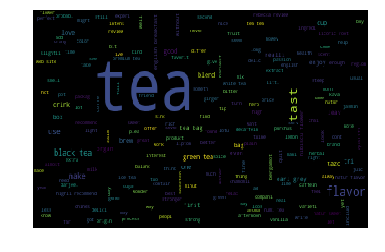

In [141]:
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(text)):
    for i in range(len(text[j])):
        t_b = t_b + text[j][i] + ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

# conclusion

* we have applied the agglomerative clustering on bag of words and created the word cloud of cluster(4) to analyse the what kind of word are there in this cluster exist.
* Most common words in cluster(4) are written in bolder size in the image. 

# Tfidf

In [142]:
tfidf_vect = TfidfVectorizer()
tfidf_train = tfidf_vect.fit_transform (X)
# sc = StandardScaler(with_mean = False)
# X_tr = sc.fit_transform(tfidf_train)

In [143]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters = 5)
s = tfidf_train.toarray()
p = agg.fit_predict(s)

In [144]:
index = []
for i in range(len(p)):
    if p[i] == 2:
        index.append(i)

In [145]:
text = []
for i in range(len(index)):
    text.append(list_of_sent[index[i]])

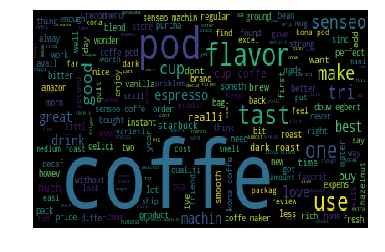

In [146]:
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(text)):
    for i in range(len(text[j])):
        t_b = t_b + text[j][i] + ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

# conclusion

* we have applied the agglomerative clustering on Tfidf and created the word cloud of cluster(2) to analyse the what kind of word are there in this cluster exists.
* Most common words in cluster(2) are written in bolder size in the image. 

# Avg W2v

In [147]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent,min_count = 5,size = 50,workers = 4)
sent_vectors = []
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    sent_vec /= cnt_word
    sent_vectors.append(sent_vec)
print(len(sent_vectors))

C:\Users\manish dogra\Documents\anaconda\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


5000


In [149]:
np.where(np.isnan(sent_vectors))

(array([2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543,
        2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543,
        2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543,
        2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543,
        2543, 2543, 2543, 2543, 2543, 2543], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], dtype=int64))

In [150]:
del sent_vectors[2543]

In [151]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
w2v = sc.fit_transform(sent_vectors)

In [152]:
p = agg.fit_predict(w2v)

In [153]:
index = []
for i in range(len(p)):
    if p[i] == 2:
        index.append(i)

In [154]:
text = []
for i in range(len(index)):
    text.append(list_of_sent[index[i]])

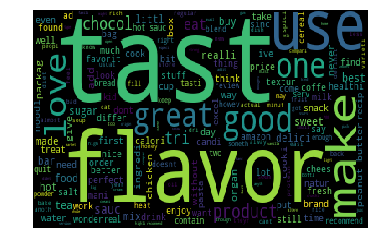

In [155]:
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(text)):
    for i in range(len(text[j])):
        t_b = t_b + text[j][i] + ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

# conclusion

* we have applied the agglomerative clustering on Avg-w2vec and created the word cloud of cluster(2) to analyse the what kind of word are there in this cluster exists.
* Most common words in cluster(2) are written in bolder size in the image. 

# Tfidf w2v

In [156]:
tf_idf_feat = tfidf_vect.get_feature_names()
tfidf_sent_vec = []
row = 0
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec/= weight_sum
    tfidf_sent_vec.append(sent_vec)
    row += 1

C:\Users\manish dogra\Documents\anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [158]:
np.where(np.isnan(tfidf_sent_vec))

(array([2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543,
        2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543,
        2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543,
        2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543, 2543,
        2543, 2543, 2543, 2543, 2543, 2543], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], dtype=int64))

In [161]:
del tfidf_sent_vec[2543]

In [162]:
sc =  StandardScaler()
tfidf_w2v = sc.fit_transform(tfidf_sent_vec)

In [164]:
p = agg.fit_predict(tfidf_w2v)

In [165]:
index = []
for i in range(len(p)):
    if p[i] == 2:
        index.append(i)

In [166]:
text = []
for i in range(len(index)):
    text.append(list_of_sent[index[i]])

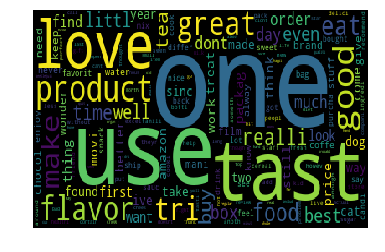

In [167]:
from wordcloud import WordCloud
from matplotlib.pyplot import figure
t_b = ''
for j in range(len(text)):
    for i in range(len(text[j])):
        t_b = t_b + text[j][i] + ' '
#print(t_b)
word_cloud = WordCloud(relative_scaling = 1.0).generate(t_b)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

# conclusion

* we have applied the agglomerative clustering on Avg-Tfidf and created the word cloud of cluster(2) to analyse the what kind of word are there in this cluster exists.
* Most common words in cluster(2) are written in bolder size in the image. 